In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import dpmm
%matplotlib inline

In [2]:
# Define a Gaussian Mixture model to test with
# This time though, assert some measurement error in MM and draw samples with
# this measurement error included.

class gauss(object):
    def __init__(self, mu, V):
        self.mu = mu # Mean
        self.V = V # Variance

    def sample(self, size=None):
        return np.random.normal(loc=self.mu, scale=np.sqrt(self.V), size=size)

    def __call__(self, x): # Probability density
        return np.exp(-0.5*(x-self.mu)**2/self.V)/np.sqrt(2*np.pi*self.V)

# Mixture model
class MM(object):
    def __init__(self, components, proportions):
        self.components = components
        self.proportions = proportions

    def sample(self, nobs=1, nsample=1, obs_err=0.0):
        samples = np.empty((nobs, nsample), dtype=float)
        interim_priors = np.empty((nobs, nsample), dtype=float)
        nums = np.random.multinomial(nobs, self.proportions) # number of objs from each mixture component
        i = 0
        for component, num in zip(self.components, nums):
            mean = component.sample(size=num)
            samples[i:i+num, :] = mean[:, np.newaxis] + np.random.normal(scale=obs_err, size=(num, nsample))
            interim_priors[i:i+num, :] = 1.0
            i += num
        return dpmm.PseudoMarginalData(np.reshape(samples, (nobs, nsample, 1)), interim_priors)

    def __call__(self, x):
        return np.sum([p*c(x) for p, c in zip(self.proportions, self.components)], axis=0)

    def plot(self, axis=None, **kwargs):
        """ Plot the mixture model pdf."""
        if axis is None:
            axis = plt.gca()
        x = np.arange(-2,2,0.01)
        y = self(x)
        axis.plot(x, y, **kwargs)

In [3]:
# Mixture model parameters
mu = [-0.5, 0.0, 0.7]  # means
V = [0.02, 0.03, 0.1]  # variances
p = [0.25, 0.4, 0.35]  # proportions
model = MM([gauss(mu0, V0) for mu0, V0 in zip(mu, V)], p)

/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


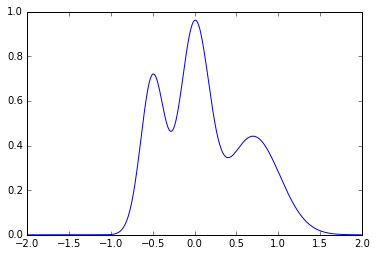

In [4]:
# Plot the generative mixture model
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
model.plot(axis=ax)
f.show()

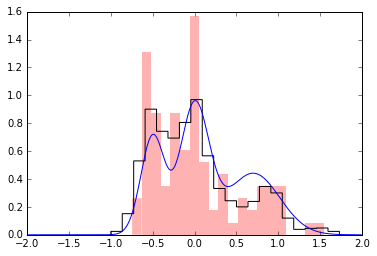

In [49]:
# Draw some samples with which to do inference, and plot the sample means.
data = model.sample(nobs=100, nsample=30, obs_err=0.1) # 100 observations, each with 10 Pseudo-Marginal samples

f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
model.plot(axis=ax)
ax.hist(np.mean(data.data, axis=1)[:, 0], 20, color='r', alpha=0.3, normed=True)
ax.hist(data.data.ravel(), 20, color='k', histtype='step', normed=True)
f.show()

In [50]:
mu_0 = 0.3
kappa_0 = 0.1
sigsqr_0 = 0.01
nu_0 = 1.0
cp = dpmm.NormInvChi2(mu_0, kappa_0, sigsqr_0, nu_0)
alpha = 1.0
dp = dpmm.DPMM(cp, alpha, data)

In [51]:
dp.update(1000)

In [52]:
phis = []
nphis = []
# Sample
for i in xrange(100):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy and not a reference.
    nphis.append(list(dp.nphi))

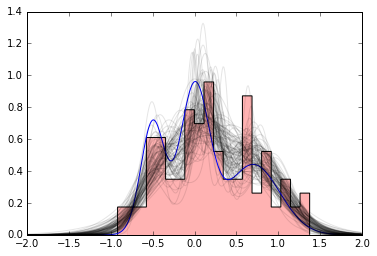

In [48]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    x = np.arange(-2, 2, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        mu, var = ph
        y += n*np.exp(-0.5*(x-mu)**2/var)/np.sqrt(2*np.pi*var)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.hist(np.mean(data.data, axis=1)[:, 0], 20, color='r', alpha=0.3, normed=True)
ax.hist(data.data.ravel(), 20, color='k', histtype='step', normed=True)
f.show()

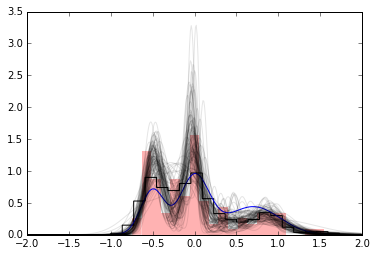

In [53]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    x = np.arange(-2, 2, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        mu, var = ph
        y += n*np.exp(-0.5*(x-mu)**2/var)/np.sqrt(2*np.pi*var)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.hist(np.mean(data.data, axis=1)[:, 0], 20, color='r', alpha=0.3, normed=True)
ax.hist(data.data.ravel(), 20, color='k', histtype='step', normed=True)
f.show()